## OT - we want to use OT concept to find pairs btwn ctrl and treatment, then using VAE get the transformations. We adjust the latent space of the VAE to introduce hierarchy and get explainability of the perturbations

### Observations and TODOs
- THERE IS A MAJOR IMPACT FROM CELL SIGNALLING IN THE EXPERIMENT which we do not account for.
- We use ONLY ONE dataset, while competitiors use external data sources. THIS IS A BIG LIMITATION unless justified or biological findings are present.
- The tree is conditional on the input. Hence, for the same pert, variability of the tree depends on the variability of the input. The latter is defined based on the OT. This is a large limitation of the method. UPD: this is fixed in the most recent version of the model.
- Removing no-pertubation pairs from the dataset leads to a much worse distinguishing of the perturbations. Apparently, model learns a lot of relationships from the no-perturbation pairs. Quantify the impact of the no-perturbation data added.
- Need to compare binary to multi-branch trees. The latter might be harder to explain but gives more variability.
- Explore no-perturbation path, all paths similar to it can be considered as not impactful. TF-based perturbations should not have this path assigned. This is yet another method test.
- Generate multiple records/paths for the same input, assess path stability and common deviations. UPD: The paths are unstable, although the high-level splits are largely fixed. This can be a good way to assess the model confidence (epistemic uncertainty?). Considering the differentiation, we are not so conditioned on the input!
- Do I need to reconstruct the type of perturbation added as extra dimensions? Would that help the model in any way? UPD: does not seem to change much

### Broader throughts
- What do external data sources give us? They introduce some prior which causes model convergence to a different minimum. The model fits "around" the exisitng knowledge. While it helps when having not enough data, it may be also limiting in the case the prior is not 100% correct. Converging with a randomised prior means more flexibility and more hypotheses, hence noisier but bigger potential for biological findings. What if we use some prior but also intrduce randomised priors from VAE or EpiNet? That should address our limitation.
- We have got path similarities within the no-perturbation cluster as well as between no-perturb and the rest of the data points. When a perturbation leads to less within-cluster specificity than the np-perturbation sample, we can PROBABLY say that there is some differentiation is taking place? This might be biologically SIGNIFICANT. Does it mean cells become more susceptible to changes e.g. cell signalling? 
- The ultimate objective is biological findings based on the PerturbSeq data. What are the ways this can be achieved?
    - Predict unknown 2-gene perturbation. As the first step, measure the quality of the current predictions on the existing dataset. Replicate the established assessment procedure from GEARS, CPA, scGPT, etc. There is no doubt that using external data, one should be able to get better prediction quality, especially of the unseen genes. Hence, we focus more on the method itself and the biological impact it might have. 
    - Generate new data points based on the learned latent tree representation. What would one do with the extra data points?
    - Assess uncertainty of the perturbations, understand what data is required to improve the model. This is a broad concept of better understanding data - requires the right context in the biological setting.
    - Assuming the performance of the method is reasonable, we need to demonstrate path similarity of the similar genes. Can we reconstruct GO or coexpression from our representation? Or maybe even find something more interesting than reproducing some part of GO.

### Critique
- There is little value in the tree path differences between the different perturbations. You can get similar information from raw expression profiles. RESPONSE: assessing the benefits of the obtained representation.
  - Comparing 9_10 perturbation paths to 0_9 and 0_10 it is evident that the overlap of the paths is shallow. The same holds for 45_50. In other words, it is rare to see the same outcome from perturbing one gene as to the one where two genes are perturbed. 
  - We might be more lucky if we have pruned multi-choice trees. This way we could see branches from both genes in the 2-gene perturbation. Might be able to classify interactions into additive, multiplicative, etc.?
  - 

### Imports

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import scanpy as scp
import pandas as pd
import numpy as np
import catboost as cb
from tqdm import tqdm
from scipy import sparse
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
import umap
from sklearn.model_selection import StratifiedKFold

import ot
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.preprocessing import QuantileTransformer

### Magics

In [3]:
GENE_PER_CELL_BINNING = False
N_BINS = 1000
N_ITER = 50
TOP_N_GENES = 576

### Prepare data

In [4]:
adata = scp.read_h5ad('./data/Norman_2019/norman_umi_go/perturb_processed.h5ad')

In [5]:
TFs = pd.read_csv('little_data/TF_db.csv',index_col=0)

In [6]:
adata.var.loc[adata.var.index.isin(TFs['Ensembl ID'].values)].index

Index(['ENSG00000078900', 'ENSG00000069812', 'ENSG00000171735',
       'ENSG00000116288', 'ENSG00000074800', 'ENSG00000120948',
       'ENSG00000116670', 'ENSG00000127483', 'ENSG00000004487',
       'ENSG00000117318',
       ...
       'ENSG00000100281', 'ENSG00000128272', 'ENSG00000235568',
       'ENSG00000159140', 'ENSG00000159216', 'ENSG00000157557',
       'ENSG00000205581', 'ENSG00000142182', 'ENSG00000160255',
       'ENSG00000160310'],
      dtype='object', name='gene_id', length=576)

In [7]:
adata = adata[:, adata.var.loc[adata.var.index.isin(TFs['Ensembl ID'].values)].index]

In [8]:
## Following the scGPT paper, we bin the genes within cell. 

def bin_nonzero_values(arr, num_bins):
    # Filter out non-zero values
    nonzero_vals = arr[arr != 0]
    
    # Calculate bin edges
    bin_edges = np.linspace(nonzero_vals.min(), nonzero_vals.max(), num_bins)
    
    # Bin the values
    binned_values = np.zeros_like(arr)
    binned_nonzero = np.digitize(nonzero_vals, bin_edges)
    binned_values[arr != 0] = binned_nonzero
    
    return binned_values

# Example usage
arr = np.random.randint(low=0, high=100, size=100)
num_bins = 3
binned_values = bin_nonzero_values(arr, num_bins)
print(set(binned_values))

{1, 2, 3}


In [9]:
scp.pp.normalize_total(adata, exclude_highly_expressed=True)
scp.pp.log1p(adata)
scp.pp.highly_variable_genes(adata, n_top_genes=TOP_N_GENES,subset=False)

/hpcfs/users/a1234104/miniconda3/envs/py310torch/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
if GENE_PER_CELL_BINNING:
    tempy = adata.X.toarray()
    
    for c in tqdm(range(adata.X.shape[0])):
        tempy[c,:] = bin_nonzero_values(tempy[c,:], N_BINS)
    
    adata.X = sparse.csr_matrix(tempy)
    del tempy

In [11]:
y = adata.obs.condition.values.astype(str)
X = adata.X.toarray()

In [12]:
gene_num_map = ['ctrl']
y_processed = []

for rec in tqdm(y):
    y_processed.append([])
    comps = rec.split('+')
    for c in comps:
        if c not in gene_num_map:
            gene_num_map.append(c)
        y_processed[-1].append(gene_num_map.index(c))
    if len(y_processed[-1])<2:
        y_processed[-1].append(gene_num_map.index('ctrl'))

100%|██████████| 91205/91205 [00:00<00:00, 183308.12it/s]


In [13]:
def pair_records_optimal_transport(set1, set2):
    """
    Pairs records from set1 with records from set2 using the optimal transport concept.
    Records from set2 can be used multiple times if needed.

    Args:
    - set1 (np.ndarray): First 2D array of records (shape: n1 x features).
    - set2 (np.ndarray): Second 2D array of records (shape: n2 x features).

    Returns:
    - pairs (list of tuples): List of index pairs (i, j) where i is the index
      from set1 and j is the index from set2 that are paired.
    """

    # Ensure the inputs are numpy arrays
    set1 = np.array(set1)
    set2 = np.array(set2)

    # Compute the cost matrix (Euclidean distance between records)
    cost_matrix = ot.dist(set1, set2, metric='euclidean')

    # Compute the optimal transport plan using linear programming
    n1, n2 = set1.shape[0], set2.shape[0]
    a = np.ones(n1) / n1  # uniform distribution on set1
    b = np.ones(n2)  # flexible distribution on set2

    # Normalize b to sum to the same total mass as a
    b = b / b.sum() * a.sum()

    transport_plan = ot.emd(a, b, cost_matrix)

    # Extract pairs based on the transport plan
    pairs = []
    for i in range(n1):
        j = np.argmax(transport_plan[i])
        pairs.append((i, j))

    return pairs

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_processed, 
                                                  test_size=0.3, 
                                                  random_state=42,
                                                  )

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  )

In [15]:
def vae_data_prep(X, y):

    # Convert list of lists to a set of tuples to find unique classes
    unique_classes = set(tuple(sorted(yi)) for yi in y)
    
    output_X = []
    output_Y = []
    labels = []
    
    # Convert y to a list of tuples for easier comparison
    y_tuples = [tuple(sorted(yi)) for yi in y]
    
    for c in tqdm(unique_classes):
        # if c == (0,0):
        #     print('skipping no-perturbation records')
        #     continue
        
        set1_indices = [i for i, yi in enumerate(y_tuples) if yi == c]
        set2_indices = [i for i, yi in enumerate(y_tuples) if yi == (0,0)]
        
        set1 = X[set1_indices]
        set2 = X[set2_indices]
        
        pairs = pair_records_optimal_transport(set1, set2)
        
        for p in pairs:
            output_X.append(set2[p[1]])
            output_Y.append(set1[p[0]])
            labels.append(c)
    
    output_X = np.array(output_X)
    output_Y = np.array(output_Y)
    
    return output_X, output_Y, labels

In [16]:
X_trainv, Y_trainv, labels_trainv = vae_data_prep(X_train, y_train)
X_valv, Y_valv, labels_valv = vae_data_prep(X_val, y_val)
X_testv, Y_testv, labels_testv = vae_data_prep(X_test, y_test)

 27%|██▋       | 63/237 [00:21<00:42,  4.13it/s]/hpcfs/users/a1234104/miniconda3/envs/py310torch/lib/python3.10/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
100%|██████████| 237/237 [00:16<00:00, 14.72it/s]


In [17]:
# X_train_r = X_trainv
# X_test_r = X_testv
# X_val_r = X_valv

# Y_train_r = Y_trainv
# Y_test_r = Y_testv
# Y_val_r = Y_valv

In [18]:
############### For a non-VAE architecture we do not need to add perturbation encoding into the input - hence commented. ################

t = np.zeros(shape=(X_trainv.shape[0], 128))
labels_trainv = np.array(labels_trainv)
np.add.at(t, (np.arange(len(labels_trainv)), labels_trainv[:, 0]), 1)
np.add.at(t, (np.arange(len(labels_trainv)), labels_trainv[:, 1]), 1)

X_train_r = np.hstack([X_trainv, t]) #pca.fit_transform(X_trainv)
Y_train_r = np.hstack([Y_trainv, t])
X_train_r[:,TOP_N_GENES+1] = 0

t = np.zeros(shape=(X_valv.shape[0], 128))
labels_valv = np.array(labels_valv)
np.add.at(t, (np.arange(len(labels_valv)), labels_valv[:, 0]), 1)
np.add.at(t, (np.arange(len(labels_valv)), labels_valv[:, 1]), 1)

X_val_r = np.hstack([X_valv, t])#pca.transform(X_valv)
Y_val_r = np.hstack([Y_valv, t])
X_val_r[:,TOP_N_GENES+1] = 0

t = np.zeros(shape=(X_testv.shape[0], 128))
labels_testv = np.array(labels_testv)
np.add.at(t, (np.arange(len(labels_testv)), labels_testv[:, 0]), 1)
np.add.at(t, (np.arange(len(labels_testv)), labels_testv[:, 1]), 1)

X_test_r = np.hstack([X_testv, t])#pca.transform(X_testv)
Y_test_r = np.hstack([Y_testv, t])
X_test_r[:,TOP_N_GENES+1] = 0

In [19]:
def labels_to_binary(x):
    # Create a binary array
    indices = np.array(x)
    binary_array = np.zeros((indices.shape[0], np.max(indices) + 1))
    
    # Set the specified indices to 1
    for i in range(binary_array.shape[0]):
        binary_array[i, indices[i, 0]] += 1
        binary_array[i, indices[i, 1]] += 1
    return binary_array
    
labels_trainv = labels_to_binary(labels_trainv)
labels_valv = labels_to_binary(labels_valv)
labels_testv = labels_to_binary(labels_testv)

In [20]:
# qt = QuantileTransformer(output_distribution='normal',random_state=42,)

# qt.fit(X_train_r)
# X_train_r = qt.transform(X_train_r)
# X_test_r = qt.transform(X_test_r)
# X_val_r = qt.transform(X_val_r)

# Y_train_r = qt.transform(Y_train_r)
# Y_test_r = qt.transform(Y_test_r)
# Y_val_r = qt.transform(Y_val_r)

In [21]:
# model = LGBMClassifier(verbose=-1, n_jobs=10)
# model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc_mu',    callbacks=[
#         lgb.early_stopping(stopping_rounds=100),
#         lgb.log_evaluation(1)
#     ])

In [22]:
device = 'cuda:0'

### VAE architecture

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [48]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims, levels, num_classes):
        super(VAE, self).__init__()

        self.levels = levels
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_class = nn.Linear(2**(self.levels+1)-1,num_classes)#, 2**(self.levels+1)-1) 
        self.fc_class2 = nn.Linear(2**(self.levels+1)-1, num_classes) 
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
        self.encoder = self.build_encoder(input_dim, latent_dim, hidden_dims)
        self.decoder = self.build_decoder(latent_dim, input_dim, hidden_dims)
        
        # Initialize the thresholds for the splits
        self.thresholds = torch.randn(2**(self.levels+1)-1).to(device)

    def build_encoder(self, input_dim, latent_dim, hidden_dims):
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5)) 
            input_dim = h_dim
        return nn.Sequential(*layers)
    
    def build_decoder(self, latent_dim, output_dim, hidden_dims):
        layers = []
        hidden_dims.reverse()
        for h_dim in hidden_dims:
            layers.append(nn.Linear(latent_dim, h_dim))
            layers.append(nn.ReLU())
            latent_dim = h_dim
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        #layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if self.training:
            eps = torch.randn_like(std)
        else:
            eps = torch.zeros_like(std)
        return mu + eps * std
    
    def mask_KINDA_WORKING_MULTI(self, z):
        levels = self.levels
        mask = (z[:, :2**(levels+1)-1] > self.thresholds).float()
        for level in range(1, levels+1):
            for i in range(2 ** level - 1, 2 ** (level + 1) - 1):

                parent_index = i // 2
                if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
                    mask[:, i] *= mask[:, parent_index - 1]
                else:  # For odd indices, mask if parent (i//2) is masked
                    mask[:, i] *= mask[:, parent_index]
    
        return torch.cat([mask * (z[:,:2**(levels+1)-1]), z[:,2**(levels+1)-1:]], axis=1) # 

    def mask(self, z):
        #WORKING_BINARY
        levels = self.levels
        mask = (z[:, :2**(levels+1)-1] > self.thresholds).float()
        for level in range(1, levels+1):
            nonzero = torch.zeros(z.shape[0]).to(device)
            for i in range(2 ** level - 1, 2 ** (level + 1) - 1):
                if (nonzero > 0).any():
                    mask[nonzero > 0, i] = 0
    
                parent_index = i // 2
                if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
                    mask[nonzero == 0, i] *= mask[nonzero == 0, parent_index - 1]
                else:  # For odd indices, mask if parent (i//2) is masked
                    mask[nonzero == 0, i] *= mask[nonzero == 0, parent_index]
    
                nonzero += mask[:, i]
    
            if (nonzero == 0).any():
                # Calculate differences between node values and thresholds
                differences = torch.abs(z[nonzero == 0, 2 ** level - 1:2 ** (level + 1) - 1] - self.thresholds[2 ** level - 1:2 ** (level + 1) - 1])
                # Find the index of the node with the smallest difference for each record
                min_difference_indices = torch.argmin(differences, dim=1)
                # Activate the node with the smallest difference for each record
                mask[nonzero == 0, 2 ** level - 1 + min_difference_indices] = 1
        
        # we want the first element be always active, after it decides on the child node. This ensures fixed representation length
        mask[:,0] = 1.0
        
        return torch.cat([mask , z[:,2**(levels+1)-1:]], axis=1) # * (z[:,:2**(levels+1)-1])

  
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, perturbs = []):
        mu, logvar = self.encode(x.to(device))
        z = self.reparameterize(mu, logvar)
        z_p = z.clone()

        z[:,:(2**(self.levels+1))-1] *= 0
        z_p = self.mask(z_p)  # Apply the mask before decoding

        class_output = (self.fc_class(z_p[:,:2**(self.levels+1)-1]))
        #class_output = self.fc_class2(class_output)

        pert_x = self.decode(z_p)
        recon_x = self.decode(z)
        
        return pert_x, recon_x, mu, logvar, class_output

def vae_loss(pert_x, y, recon_x, x, mu, logvar, class_output, class_labels, levels):
    tree_KLD_opt = False
    x = x.to(device)
    recon_loss = nn.functional.mse_loss(recon_x[:,:TOP_N_GENES], x[:,:TOP_N_GENES], reduction='sum')
    pert_loss = nn.functional.mse_loss(pert_x[:,:TOP_N_GENES], y[:,:TOP_N_GENES], reduction='sum')
    class_loss = nn.functional.mse_loss(class_output, class_labels.type(torch.float32)) #binary_cross_entropy_with_logits
    if not tree_KLD_opt:
        kl_loss = -0.5 * torch.sum(1 + logvar[:,(2**(levels+1))-1:] - mu[:,(2**(levels+1))-1:].pow(2) - logvar[:,(2**(levels+1))-1:].exp())
    else:
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss, pert_loss/100, kl_loss, class_loss*1e9

def train_vae(model, train_loader, val_loader, epochs, learning_rate=1e-3, step_size=5, gamma=0.1, patience=7):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    model.train()
    
    best_loss = 1e6
    
    train_losses = []
    val_losses = []
    no_improve_epochs = 0
    for epoch in range(epochs):
        total_train_recon_loss = 0
        total_train_pert_loss = 0
        total_train_kl_loss = 0
        total_train_class_loss = 0
        for batch_ctrl, batch_pert, pert_labels in train_loader:
            optimizer.zero_grad()
            batch_ctrl = batch_ctrl.to(device)
            batch_pert = batch_pert.to(device)
            
            class_labels = pert_labels.to(device)
                        
            pert_x, recon_x, mu, logvar, class_output = model(batch_ctrl, pert_labels)
            
            z = model.reparameterize(mu, logvar)
            recon_loss, pert_loss, kl_loss, class_loss = vae_loss(pert_x, batch_pert, recon_x, batch_ctrl, mu, logvar, class_output, class_labels, levels=model.levels)
            loss =  pert_loss + class_loss + recon_loss #+ kl_loss# + pert_loss +  +
            loss.backward()
            optimizer.step()
            total_train_recon_loss += recon_loss.item()
            total_train_pert_loss += pert_loss.item()
            total_train_kl_loss += kl_loss.item()
            total_train_class_loss += class_loss.item()
        scheduler.step()
        print(f"----Current LR is {scheduler.get_lr()}----")
        
        avg_train_recon_loss = total_train_recon_loss / len(train_loader.dataset)
        avg_train_pert_loss = total_train_pert_loss / len(train_loader.dataset)
        avg_train_kl_loss = total_train_kl_loss / len(train_loader.dataset)
        avg_train_class_loss = total_train_class_loss / len(train_loader.dataset)
        train_losses.append((avg_train_recon_loss, avg_train_pert_loss, avg_train_kl_loss, avg_train_class_loss))
        
        model.eval()
        total_val_recon_loss = 0
        total_val_pert_loss = 0
        total_val_kl_loss = 0
        total_val_class_loss = 0
        with torch.no_grad():
            for batch_ctrl, batch_pert, pert_labels in val_loader:

                batch_ctrl = batch_ctrl.to(device)
                batch_pert = batch_pert.to(device)
                class_labels = pert_labels.to(device)
                
                pert_x, recon_x, mu, logvar, class_output = model(batch_ctrl, pert_labels)
                z = model.reparameterize(mu, logvar)
                recon_loss, pert_loss, kl_loss, class_loss = vae_loss(pert_x, batch_pert, recon_x, batch_ctrl, mu, logvar, class_output, class_labels, levels=model.levels)
                total_val_recon_loss += recon_loss.item()
                total_val_pert_loss += pert_loss.item()
                total_val_kl_loss += kl_loss.item()
                total_val_class_loss += class_loss.item()
        
        avg_val_recon_loss = total_val_recon_loss / len(val_loader.dataset)
        avg_val_pert_loss = total_val_pert_loss / len(val_loader.dataset)
        avg_val_kl_loss = total_val_kl_loss / len(val_loader.dataset)
        avg_val_class_loss = total_val_class_loss / len(val_loader.dataset)
        val_losses.append((avg_val_recon_loss, avg_val_pert_loss, avg_val_kl_loss,avg_val_class_loss))
        
        current_loss = avg_val_class_loss +avg_val_pert_loss +avg_val_recon_loss #+ avg_val_kl_loss # avg_val_recon_loss
        if current_loss < best_loss:
            best_loss = current_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        model.train()

        # Plotting the losses
        clear_output(wait=True)
        fig, ax = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(10, 7))
        
        # Calculate minimum loss values
        min_train_recon_loss = min([x[0] for x in train_losses])
        min_train_pert_loss = min([x[1] for x in train_losses])
        min_train_kl_loss = min([x[2] for x in train_losses])
        min_train_class_loss = min([x[3] for x in train_losses])
        
        min_val_recon_loss = min([x[0] for x in val_losses])
        min_val_pert_loss = min([x[1] for x in val_losses])
        min_val_kl_loss = min([x[2] for x in val_losses])
        min_val_class_loss = min([x[3] for x in val_losses])
        
        # Plot training losses
        ax[0].plot([x[0] for x in train_losses], label='Train Recon Loss')
        ax[0].set_title(f'Min Train Recon Loss: {min_train_recon_loss:.2E}')
        ax[1].plot([x[1] for x in train_losses], label='Train Pert Loss')
        ax[1].set_title(f'Min Train Pert Loss: {min_train_pert_loss:.2E}')
        ax[2].plot([x[2] for x in train_losses], label='Train KL Loss')
        ax[2].set_title(f'Min Train KL Loss: {min_train_kl_loss:.2E}')
        ax[3].plot([x[3] for x in train_losses], label='Train Class Loss')
        ax[3].set_title(f'Min Train Class Loss: {min_train_class_loss:.2E}')
        
        # Plot validation losses
        ax[0].plot([x[0] for x in val_losses], label=f'Val Recon Loss; Best: {np.argmin([x[0] for x in val_losses])}')
        ax[0].set_title(f'Min Val Recon Loss: {min_val_recon_loss:.2E}')
        ax[1].plot([x[1] for x in val_losses], label=f'Val Pert Loss; Best: {np.argmin([x[1] for x in val_losses])}')
        ax[1].set_title(f'Min Val Pert Loss: {min_val_pert_loss:.2E}')
        ax[2].plot([x[2] for x in val_losses], label=f'Val KL Loss; Best: {np.argmin([x[2] for x in val_losses])}')
        ax[2].set_title(f'Min Val KL Loss: {min_val_kl_loss:.2E}')
        ax[3].plot([x[3] for x in val_losses], label=f'Val Class Loss; Best: {np.argmin([x[3] for x in val_losses])}')
        ax[3].set_title(f'Min Val Class Loss: {min_val_class_loss:.2E}')        
        # Add legends
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        plt.show()


In [49]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, labels):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.labels = labels
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.labels[idx]

In [50]:
train_dataset = CustomDataset(X_train_r[:,:], Y_train_r[:,:], labels_trainv)
val_dataset = CustomDataset(X_val_r[:,:], Y_val_r[:,:], labels_valv)
test_dataset = CustomDataset(X_test_r[:,:], Y_test_r[:,:], labels_testv)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

input_dim = X_train_r.shape[1]
latent_dim = 600
hidden_dims = [6000]
epochs = 600
learning_rate = 4e-4

In [51]:
vae = VAE(input_dim, latent_dim, hidden_dims, levels=5, num_classes=106).to(device)
n_dims_g = 2**(vae.levels+1)-1

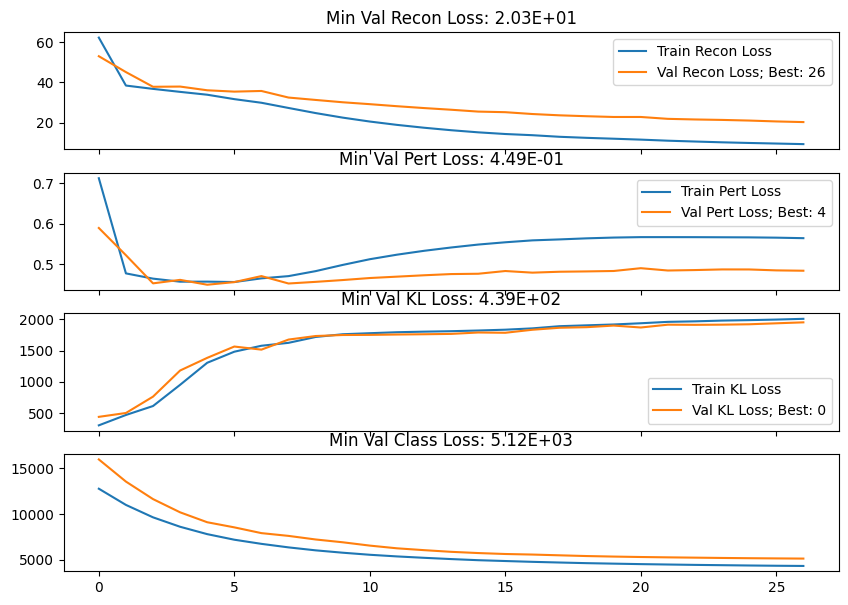

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7fbef42fbe20>
Traceback (most recent call last):
  File "/hpcfs/users/a1234104/miniconda3/envs/py310torch/lib/python3.10/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [52]:
train_vae(vae, train_loader, val_loader, epochs, learning_rate, gamma=0.9, patience=15)

#### Checking the distances between the 2-gene perturbations and its components

In [54]:
# distances between 2-gene pert and its components
latent_rep = []
pert_labels_all = []
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in val_loader:
        pert_x, recon_x, mu, logvar, _ = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        masked_z = vae.mask(z)[:,:n_dims_g].cpu().numpy()
        latent_rep.append(masked_z)
        pert_labels_all.append(pert_labels.cpu().numpy())

masked_z = np.vstack(latent_rep)
pert_labels_all = np.vstack(pert_labels_all)

In [55]:
p1 = np.zeros((1,106))
p1[:,0] = 1
p1[:,9] = 1
p2 = np.zeros((1,106))
p2[:,0] = 1
p2[:,10] = 1
p3 = np.zeros((1,106))
p3[:,9:11] = 1
all_perts = [p1,p2,p3]

for pert in all_perts:
    for pert2 in all_perts:
        temp = masked_z[(pert_labels_all==pert).all(axis=1)]
        temp_rest = masked_z[(pert_labels_all==pert2).all(axis=1)]
        
        distance_mtx = np.zeros(shape=(temp.shape[0],temp_rest.shape[0]))
        for i in range(temp.shape[0]):
            for j in range(temp_rest.shape[0]):
                
                inds1 = np.arange(temp.shape[1])[(temp[i]!=0)]
                inds2 = np.arange(temp_rest.shape[1])[(temp_rest[j]!=0)]
                
                distance_mtx[i,j] = len(set(inds1.tolist()).intersection(set(inds2.tolist())))
                
        print(f"{np.nonzero(pert)[1]}->{np.nonzero(pert2)[1]} \t\t {distance_mtx.mean():1.2f}")

[0 9]->[0 9] 		 2.45
[0 9]->[ 0 10] 		 2.44
[0 9]->[ 9 10] 		 2.54
[ 0 10]->[0 9] 		 2.44
[ 0 10]->[ 0 10] 		 2.46
[ 0 10]->[ 9 10] 		 2.56
[ 9 10]->[0 9] 		 2.54
[ 9 10]->[ 0 10] 		 2.56
[ 9 10]->[ 9 10] 		 2.81


#### The following analysis is done on a signle batch

In [106]:
# For testing, you run the model in evaluation mode
vae.eval()
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in val_loader:
        pert_x, recon_x, mu, logvar, _ = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        masked_z = vae.mask(z)[:,:n_dims_g].cpu().numpy()
        break

In [86]:
# # distances between the target cluster and the rest of the dataset
# print("Distances between the target cluster and the rest of the dataset")

# all_perts = np.unique(pert_labels.cpu().numpy(),axis=0)

# for pert in all_perts:
#     temp = masked_z[(pert_labels.cpu().numpy()==pert).all(axis=1)]
#     temp_rest = masked_z[(pert_labels.cpu().numpy()!=pert).any(axis=1)]
#     distance_mtx = np.zeros(shape=(temp.shape[0],temp_rest.shape[0]))
#     for i in range(temp.shape[0]):
#         for j in range(temp_rest.shape[0]):
            
#             inds1 = np.arange(temp.shape[1])[(temp[i]!=0)]
#             inds2 = np.arange(temp_rest.shape[1])[(temp_rest[j]!=0)]
#             distance_mtx[i,j] = len(set(inds1.tolist()).intersection(set(inds2.tolist())))
            
#     print(f"{np.nonzero(pert)[0]} \t {distance_mtx.mean():1.2f}")

#### Let's see how diverse is the no-perturbation latent representation

In [107]:
pnull = np.zeros((1,106))
pnull[:,0] = 2

nopert = masked_z[(np.array(pert_labels)==pnull).all(axis=1)]
nopert[nopert!=0] = 1
nopert_s = []
for i in range(nopert.shape[0]):
    nopert_s.append(np.arange(n_dims_g)[(nopert!=0)[i,:]])
print('Number of unique paths: ', np.unique(nopert, axis=0).shape[0])
nopert_s = [str(i) for i in nopert_s]
#Counter(nopert_s)

Number of unique paths:  1


In [108]:
no_pert_path = np.arange(nopert[0].shape[0])[np.unique(nopert, axis=0)[0].astype(bool)][:6]

In [89]:
# print("Distances within the target cluster")
# all_perts = np.unique(pert_labels.cpu().numpy(),axis=0)

# print(f"Mean distance within cluster \t Path overlap with to no-perturb")
# for pert in all_perts:
#     temp = masked_z[(pert_labels.cpu().numpy()==pert).all(axis=1)]
#     temp[temp!=0] = 1
#     distance_mtx = np.zeros(shape=(temp.shape[0],temp.shape[0]))
#     counter = 0
#     pos_counter = 0
#     for i in range(temp.shape[0]):
#         for j in range(temp.shape[0]):
            
#             inds1 = np.arange(temp.shape[1])[(temp[i]!=0)]
#             inds2 = np.arange(temp.shape[1])[(temp[j]!=0)]
#             if (inds1[:6] == no_pert_path).all():
#                 pos_counter+=1
#             counter+=1
#             distance_mtx[i,j] = len(set(inds1.tolist()).intersection(set(inds2.tolist())))
    
#     print(f"{np.nonzero(pert)[0]}: \t{distance_mtx.mean():1.2f}\t\t\t {pos_counter/(counter):1.2f}")
#     counter = 0
#     pos_counter=0

In [109]:
print('Building a similarity matrix for the first 512 data points')
n_dims = n_dims_g
paths = []
distance_mtx = np.zeros((512, 512))
for i in tqdm(range(512)):
    for j in range(i, 512):
        inds1 = np.arange(n_dims)[(masked_z[i, -n_dims:]!=0)]
        inds2 = np.arange(n_dims)[(masked_z[j, -n_dims:]!=0)]
        
        # for level in range(vae.levels+1):
        #     inds1t = inds1[(inds1>2**min(level-1,0)) & (inds1<2**level)]
        #     inds2t = inds2[(inds2>2**min(level-1,0)) & (inds2<2**level)]
        #     distance_mtx[i, j] += 2*level * len(set(inds1t.tolist()).intersection(set(inds2t.tolist())))#/(min(len(inds1),len(inds2))+1)
        distance_mtx[i, j] = len(set(inds1.tolist()).intersection(set(inds2.tolist())))#/(min(len(inds1),len(inds2))+1)
for i in range(512):
    for j in range(i, 512):
        distance_mtx[j, i] = distance_mtx[i, j]

Building a similarity matrix for the first 512 data points


100%|██████████| 512/512 [00:01<00:00, 414.07it/s]


In [110]:
print('Measure similarity within the first and second perturbation, then between them')
distance_mtx[11:39,11:39].mean(), distance_mtx[:11,:11].mean(), distance_mtx[11:39,:11].mean()

Measure similarity within the first and second perturbation, then between them


(8.681122448979592, 9.256198347107437, 8.00974025974026)

In [111]:
distance_mtx.mean()

9.326484680175781

<Axes: >

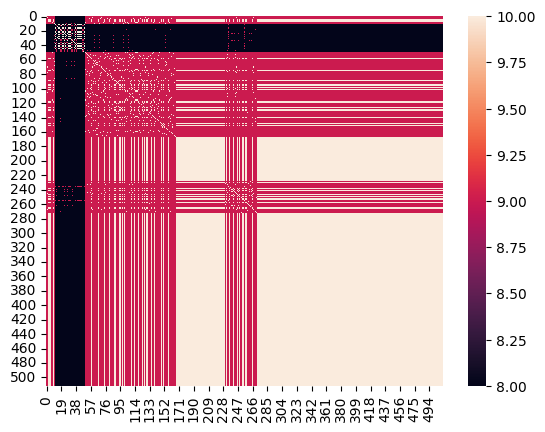

In [112]:
import seaborn as sns
sns.heatmap(distance_mtx)

Text(0.5, 1.0, 'Distribution of the similarities (tree representation)')

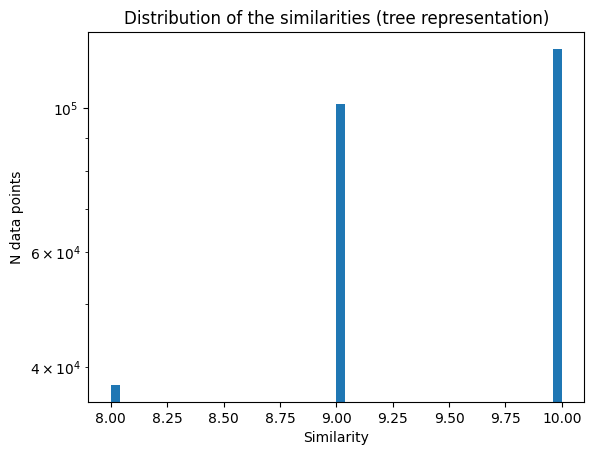

In [113]:
plt.hist(distance_mtx.ravel(),bins=50, log=True)
plt.xlabel('Similarity')
plt.ylabel('N data points')
plt.title('Distribution of the similarities (tree representation)')

### Let's get a UMAP of this and see whether clusters resemble the perturbations

In [212]:
# For testing, you can run the model in evaluation mode
vae.eval()
masked_z = []
first_all = []
second_all = []
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in val_loader:
        pert_x, recon_x, mu, logvar, _ = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        t_masked_z = vae.mask(z)[:,:n_dims_g].cpu().numpy()
        masked_z.append(t_masked_z)
        first_all.extend(pert_labels[:,0].cpu().numpy()) 
        second_all.extend(pert_labels[:,1].cpu().numpy()) 

In [213]:
z = np.vstack(masked_z)

In [214]:
first = first_all
second = second_all
colors = []
for i in range(len(first)):
    colors.append(str(int(first[i]))+'_'+str(int(second[i])))

unique_colors = np.unique(colors)
color_map = {color: i for i, color in enumerate(unique_colors)}

# Convert colors to numeric values
numeric_colors = np.array([color_map[color] for color in colors])

In [215]:
import umap.umap_ as umap

# Apply UMAP
reducer = umap.UMAP(n_components=2,)
embedding = reducer.fit_transform(z[:,:])

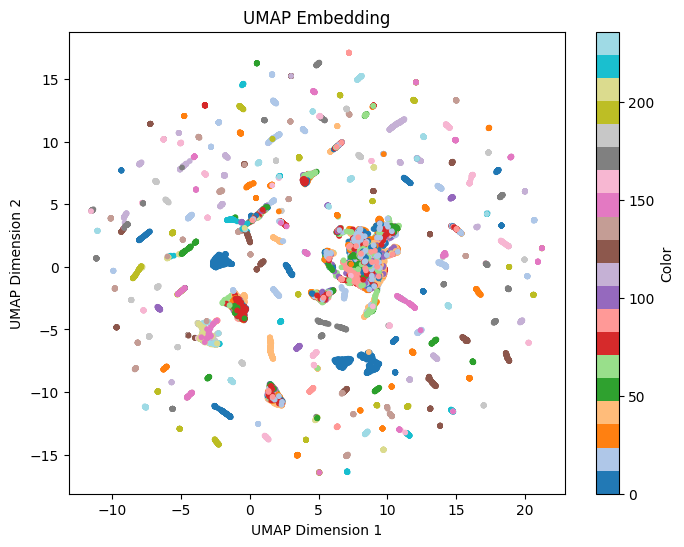

In [216]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=numeric_colors, cmap='tab20', s=10,alpha=0.99)
plt.title("UMAP Embedding")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Color")
plt.show()

### Let's explore unique records and gene-characteristic splits

In [88]:
# For testing, you can run the model in evaluation mode
vae.eval()
masked_z = []
first_all = []
second_all = []
inputs = []
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in test_loader:
        pert_x, recon_x, mu, logvar, _ = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        t_masked_z = vae.mask(z)[:,:n_dims_g].cpu().numpy()
        masked_z.append(t_masked_z)
        first_all.extend(pert_labels[:,0].cpu().numpy()) 
        second_all.extend(pert_labels[:,1].cpu().numpy()) 
        inputs.extend(batch_ctrl.cpu().numpy()) 
        
first = first_all
second = second_all
colors = []
for i in range(len(first)):
    colors.append(str(int(first[i]))+'_'+str(int(second[i])))
colors = np.array(colors)
masked_z = np.vstack(masked_z)
inputs = np.vstack(inputs)

In [40]:
masked_z[masked_z!=0] = 1

In [41]:
np.unique(masked_z,axis=0).shape

(1105, 255)

In [409]:
import numpy as np

def identify_contrast_features(masked_z, colors, target_class, threshold=0.1):
    """
    Identifies binary features that show a contrast between the target class and other classes.

    Args:
        masked_z (np.ndarray): Binary 2D array with shape (n_samples, n_features).
        colors (np.ndarray): 1D array of class labels (e.g., [0, 1, 2, ...]).
        target_class (int): The class for which to identify contrast features.
        threshold (float, optional): Minimum difference in feature activation between target class and other classes.
            Defaults to 0.1.

    Returns:
        list: List of indices corresponding to contrast features for the target class.
    """
    # Initialize an empty list to store contrast feature indices
    contrast_feature_indices = []

    # Get the feature values for the target class
    feature_values_for_target = masked_z[colors == target_class]
    
    # Calculate the proportion of active features for the target class
    target_class_proportion = np.mean(feature_values_for_target, axis=0)
    # Iterate over each feature
    for feature_idx in range(masked_z.shape[1]):
        # Get the feature values for all other classes
        other_classes = np.unique(colors[colors != target_class])
        other_feature_values = masked_z[colors != target_class, feature_idx]

        # Calculate the proportion of active features for other classes
        other_classes_proportion = np.mean(other_feature_values, axis=0)

        # Calculate the difference in proportions
        difference = target_class_proportion[feature_idx] - other_classes_proportion
        
        # Check if the difference exceeds the threshold
        if difference > threshold:
            contrast_feature_indices.append((feature_idx, difference))

    return contrast_feature_indices


for c in list(set(colors)):
    print(c, identify_contrast_features(masked_z, colors, c, threshold=0.75))

0_91 []
18_19 [(191, 0.7680275)]
0_32 []
0_11 []
20_35 [(192, 0.9002168), (386, 0.8975785)]
70_81 [(191, 0.77682376)]
2_74 []
0_33 []
0_58 []
13_61 [(192, 0.9419934), (386, 0.9393551)]
0_3 []
0_66 []
0_70 []
0_53 []
0_34 []
0_27 []
24_35 [(192, 0.85983276), (386, 0.85719323)]
26_64 []
12_31 [(6, 0.8677616), (13, 0.91326815), (27, 0.9114966), (56, 0.8756704), (113, 0.8663536), (227, 0.8676453)]
2_3 []
2_56 [(191, 0.82407105), (383, 0.85253656)]
18_80 []
18_71 [(191, 0.8101214)]
42_87 []
0_92 []
0_105 []
41_65 [(56, 0.7636678), (113, 0.7656858), (227, 0.76697)]
0_23 []
0_38 []
0_44 []
4_14 [(191, 0.82259244), (383, 0.851007)]
3_15 [(12, 0.8604863), (25, 0.8624309), (51, 0.8624309), (103, 0.8624309), (207, 0.8624309), (415, 0.8624309)]
51_52 []
42_94 [(383, 0.7590909)]
9_61 [(6, 0.8610877), (13, 0.9062443), (27, 0.90448636)]
0_63 []
0_90 []
0_7 []
4_10 [(191, 0.7851498), (383, 0.81361747)]
16_65 []
13_35 [(192, 0.8226445), (386, 0.8200074)]
98_104 []
0_48 []
17_94 []
11_31 [(6, 0.81753856

In [630]:
from collections import Counter
Counter(colors)

Counter({'0_0': 2146,
         '0_2': 496,
         '0_25': 357,
         '0_4': 350,
         '4_5': 314,
         '0_10': 306,
         '0_16': 290,
         '12_31': 267,
         '0_41': 258,
         '0_32': 252,
         '10_53': 251,
         '0_15': 246,
         '0_80': 241,
         '0_66': 237,
         '0_18': 227,
         '0_3': 227,
         '0_22': 225,
         '0_64': 217,
         '0_29': 217,
         '0_71': 207,
         '0_13': 207,
         '0_26': 195,
         '0_5': 190,
         '10_13': 189,
         '0_60': 187,
         '0_61': 187,
         '16_41': 184,
         '0_35': 183,
         '0_37': 182,
         '0_81': 181,
         '0_24': 177,
         '0_31': 175,
         '0_12': 172,
         '0_42': 171,
         '58_72': 171,
         '15_30': 169,
         '2_29': 169,
         '4_29': 169,
         '0_53': 168,
         '0_89': 167,
         '0_45': 166,
         '0_9': 164,
         '0_74': 162,
         '15_27': 161,
         '3_27': 157,
         

In [398]:
target_pert = masked_z[colors == '0_0']
last = []
print(target_pert.shape[0])
for i in range(target_pert.shape[0]):
    last.append(np.arange(n_dims_g)[(target_pert!=0)[i,:]][-1])
len(set(last))

2146


2

In [296]:
target_pert = masked_z[:10]
for i in range(target_pert.shape[0]):
    print(np.arange(n_dims_g)[(target_pert!=0)[i,:]])

[ 1  3  7 15 31 63]
[ 2  5 11 24 40 81]
[ 1  3  7 15 31 63]
[ 2  5 11 24 36 73]
[ 2  5 11 23 47 95]
[ 2  5 11 23 47 95]
[ 2  5 11 23 47 95]
[ 1  3  7 15 31 63]
[ 1  3 10 21 43 87]
[ 2  5 11 23 47 95]


In [303]:
np.mean(np.abs(inputs[4] - inputs[5])), np.mean(np.abs(inputs[0] - inputs[2])), np.mean(np.abs(inputs[0] - inputs[1]))

(0.12841444, 0.12897287, 0.1362692)

This points at the fact that the latent representation is largely conditional on the input gene expressions and not necessarily perturbation itself.

### Build similarity matrix between single-gene perturbations

In [114]:
vae.training = False
latent_rep = []
pert_labels_all = []
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in val_loader:
        for i in range(1):
            pert_x, recon_x, mu, logvar, _ = vae(batch_ctrl, pert_labels)
            z = vae.reparameterize(mu, logvar)
            masked_z = vae.mask(z)[:,:n_dims_g].cpu().numpy()
            latent_rep.append(masked_z)
            pert_labels_all.append(pert_labels.cpu().numpy())

masked_z = np.vstack(latent_rep)
pert_labels_all = np.vstack(pert_labels_all)
filt = (pert_labels_all[:,0] == 1)

In [115]:
gene_labels = np.array(gene_num_map)[np.nonzero(pert_labels_all[filt])[1][1::2]]
masked_z = masked_z[filt]

In [116]:
from numba import jit

@jit(nopython=True)
def calculate_distance(t1_row, t2_row, levels, hier=False):
    inds1 = np.nonzero(t1_row)[0]
    inds2 = np.nonzero(t2_row)[0]
    
    if hier:
        distance = 0.0
        for level in range(1, levels + 1):
            lower = 2 ** (level - 1)
            upper = 2 ** level
            inds1t = inds1[(inds1 > lower) & (inds1 <= upper)]
            inds2t = inds2[(inds2 > lower) & (inds2 <= upper)]
            distance += 2 * level * np.intersect1d(inds1t, inds2t).size
    else:
        distance = np.intersect1d(inds1, inds2).size
    return distance

@jit(nopython=True)
def calculate_distance_matrix(t1, t2, levels, hier=False):
    distance_mtx = np.zeros((t1.shape[0], t2.shape[0]))
    for i in range(t1.shape[0]):
        for j in range(t2.shape[0]):
            distance_mtx[i, j] = calculate_distance(t1[i], t2[j], levels, hier)
    return distance_mtx

def optimized_similarity_calculation(masked_z, gene_labels, vae_levels, hier=False):
    unique_labels = np.unique(gene_labels)
    final_sim_mtx = pd.DataFrame(index=unique_labels, columns=unique_labels)

    for pert in tqdm(unique_labels):
        t1 = masked_z[gene_labels == pert]
        for pert2 in unique_labels:
            t2 = masked_z[gene_labels == pert2]
            distance_mtx = calculate_distance_matrix(t1, t2, vae_levels, hier)
            final_sim_mtx.loc[pert, pert2] = distance_mtx.mean()

    return final_sim_mtx

# Usage
final_sim_mtx = optimized_similarity_calculation(masked_z, gene_labels, vae.levels, hier=False)

100%|██████████| 105/105 [03:05<00:00,  1.76s/it]


In [117]:
final_sim_mtx.to_csv('./little_data/VAE_tree_similarities.csv')

### Let's explore the actual paths for 2-gene perts and their components

In [85]:
t = pert_labels.cpu().numpy()

In [91]:
np.unique(colors)

array(['0_0', '0_1', '0_10', '0_100', '0_101', '0_102', '0_103', '0_104',
       '0_105', '0_11', '0_12', '0_13', '0_14', '0_15', '0_16', '0_17',
       '0_18', '0_19', '0_2', '0_20', '0_21', '0_22', '0_23', '0_24',
       '0_25', '0_26', '0_27', '0_28', '0_29', '0_3', '0_30', '0_31',
       '0_32', '0_33', '0_34', '0_35', '0_36', '0_37', '0_38', '0_39',
       '0_4', '0_40', '0_41', '0_42', '0_43', '0_44', '0_45', '0_46',
       '0_47', '0_48', '0_49', '0_5', '0_50', '0_51', '0_52', '0_53',
       '0_54', '0_55', '0_56', '0_57', '0_58', '0_59', '0_6', '0_60',
       '0_61', '0_62', '0_63', '0_64', '0_65', '0_66', '0_67', '0_68',
       '0_69', '0_7', '0_70', '0_71', '0_72', '0_73', '0_74', '0_75',
       '0_76', '0_77', '0_78', '0_79', '0_8', '0_80', '0_81', '0_82',
       '0_83', '0_84', '0_85', '0_86', '0_87', '0_88', '0_89', '0_9',
       '0_90', '0_91', '0_92', '0_93', '0_94', '0_95', '0_96', '0_97',
       '0_98', '0_99', '10_13', '10_20', '10_24', '10_35', '10_53',
       '10_61

In [170]:
# For testing, you can run the model in evaluation mode
record_n = 0
vae.training = True
masked_z = []
first_all = []
second_all = []
inputs = []
perturb_cells = []
switch=0

pert_of_interest = torch.Tensor([45,50])

with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in test_loader:
        pert_x, recon_x, mu, logvar, _ = vae(batch_ctrl, pert_labels)
        for i in range(100):
            m = (pert_labels == pert_of_interest)
            m = m.all(axis=1)
            try:
                z = vae.reparameterize(mu[m,:], logvar[m,:])
                if z.shape[0]<1:
                    continue
            except Exception as e:
                print(e)
                continue
            t_masked_z = vae.mask(z)[:,:n_dims_g].cpu().numpy()
            pert_x = vae.decode(vae.mask(z))
            perturb_cells.append(pert_x.detach().cpu().numpy())
            masked_z.append(t_masked_z)
            first_all.extend(pert_labels[m,0].cpu().numpy())
            second_all.extend(pert_labels[m,1].cpu().numpy())
            #inputs.extend(batch_ctrl[].cpu().numpy()) 
            switch = 1
        if switch:
            break
        
first = first_all
second = second_all
colors = []
for i in range(len(first)):
    colors.append(str(int(first[i]))+'_'+str(int(second[i])))
colors = np.array(colors)
masked_z = np.vstack(masked_z)
perturb_cells = np.vstack(perturb_cells)
#inputs = np.vstack(inputs)

In [172]:
ctrl = adata[adata.obs[adata.obs.condition=='ctrl'].index].X[:,:].toarray()
p = adata[adata.obs[adata.obs.condition=='TSC22D1+ctrl'].index].X[:,:].toarray()

In [173]:
# import numpy as np
# from scipy.stats import ttest_ind

# def find_differentially_expressed_genes(expression_treatment, expression_control, alpha=0.05, thr = 1.0):
#     """
#     Finds differentially expressed genes between treatment and control groups.

#     Args:
#         expression_treatment (np.ndarray): Gene expression data for the treatment group (n_cells x n_genes).
#         expression_control (np.ndarray): Gene expression data for the control group (n_cells x n_genes).
#         alpha (float, optional): Significance level for t-test. Defaults to 0.05.

#     Returns:
#         np.ndarray: Boolean array indicating DEGs (True for DEGs, False otherwise).
#     """
#     # Calculate mean expression for each gene in treatment and control groups
#     mean_treatment = np.mean(expression_treatment, axis=0)
#     mean_control = np.mean(expression_control, axis=0)

#     # Calculate variance for each gene in treatment and control groups
#     var_treatment = np.var(expression_treatment, axis=0, ddof=1)
#     var_control = np.var(expression_control, axis=0, ddof=1)

#     # Calculate fold change (FC) for each gene
#     fc = (mean_treatment - mean_control) / np.sqrt(var_treatment + var_control)

#     # Perform two-sample t-test for each gene
#     _, p_values = ttest_ind(expression_treatment, expression_control, axis=0,)

#     # Adjust p-values for multiple testing (e.g., using Bonferroni correction)
#     num_genes = expression_treatment.shape[1]
#     adjusted_alpha = alpha / num_genes
    
#     significant_genes = p_values < adjusted_alpha
    
#     # Identify DEGs based on FC and adjusted p-value
#     degs = np.logical_and(significant_genes, np.abs(fc) > thr)

#     return degs

# # Find DEGs
# degs = find_differentially_expressed_genes(perturb_cells[:,:500], ctrl, alpha=0.01,thr=0.5)
# print("Indices of differentially expressed genes synthetic:")
# print(np.where(degs)[0])

# degs = find_differentially_expressed_genes(p, ctrl, alpha=0.01,thr=0.1)
# print("Indices of differentially expressed genes ground truth:")
# print(np.where(degs)[0])

In [174]:
target_pert = masked_z
reps = []
for i in range(target_pert.shape[0]):
    reps.append(np.arange(n_dims_g)[(target_pert!=0)[i,:]])

In [175]:
len(reps)

9800

In [176]:
reps_l = [str(i) for i in reps]

In [177]:
from collections import Counter
t = np.array(reps)
Counter(reps_l,axis=0)

Counter({'[  0   1   3  14  30  60 122 242]': 4440,
         '[  0   1   3  14  30  60 122 130]': 1051,
         '[  0   1   3   7  15  60 122 242]': 568,
         '[  0   1   3  14  30  60 122 245]': 491,
         '[  0   1   3  14  30  60 122 164]': 478,
         '[  0   1   3   7  15  60 122 164]': 466,
         '[  0   1   3   7  15  60 122 175]': 367,
         '[  0   1   3   7  15  60 122 184]': 366,
         '[  0   1   3  14  30  60 122 184]': 310,
         '[  0   1   3  14  30  60 122 175]': 289,
         '[  0   1   3  14  30  60 122 241]': 225,
         '[  0   1   3  14  30  60 122 147]': 174,
         '[  0   1   3  14  30  60 122 226]': 169,
         '[  0   1   3  14  30  60 122 174]': 163,
         '[  0   1   3   7  15  60 122 130]': 99,
         '[  0   1   3   7  15  60 122 174]': 59,
         '[  0   1   3  10  22  45  91 184]': 43,
         '[  0   1   3   7  15  60 122 147]': 29,
         '[  0   1   3  14  30  60 122 218]': 10,
         '[  0   1   3  14  30  60